# Deep Learning and Medical Imaging - Digital Pathology

In this exercise, we will solve the same problem as before, i.e. we have images corresponding to 2 categories and we would like to train a classifier that can separate between the two sets of images. However, in this case we are looking at HE-stained digital pathology images (i.e. RGB images instead of grayscale images), where we will try to separate between epithelium and stroma regions.

## Imports, sampling and data loading

We start by downloading the data that we will use. 

The data is downloaded from http://www.andrewjanowczyk.com/deep-learning/. The datasets available on this webpage were published in conjunction with a tutorial on deep learning for digital pathology (http://www.jpathinformatics.org/text.asp?2016/7/1/29/186902). Feel free to check this out if you want to explore the topic of deep learning and digital pathology any further.


In [1]:
# Run the below lines to download and unpack the data when running in Colab.
# Remember to uncomment.
# !wget -O epi.tar http://andrewjanowczyk.com/wp-static/epi.tgz
# !mkdir epi
# !tar -xf epi.tar -C epi

--2019-03-19 15:18:02--  http://andrewjanowczyk.com/wp-static/epi.tgz
Resolving andrewjanowczyk.com (andrewjanowczyk.com)... 129.22.136.73
Connecting to andrewjanowczyk.com (andrewjanowczyk.com)|129.22.136.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352039805 (336M) [application/x-gzip]
Saving to: ‘epi.tar’

epi.tar             100%[===================>] 335.73M  1.72MB/s    in 4m 10s  

2019-03-19 15:22:13 (1.34 MB/s) - ‘epi.tar’ saved [352039805/352039805]

mkdir: cannot create directory ‘epi’: File exists


This time, the data has not been sampled, hence we need to create the samples (image patches) ourselves. The original images are located in the folder "epi" and the masks for epithelium in the subfolder "masks".

In [0]:
import os
import glob

folder = "epi"

# Find all images and mask images
orig_images = glob.glob(os.path.join(folder,"*.tif"))
mask_images = glob.glob(os.path.join(folder,"masks","*.png"))

# Not all images have mask images, so we need to find those that do
orig_images_with_mask = list()
orig_image_names = [os.path.splitext(os.path.basename(fname))[0] for fname in orig_images]
mask_image_names = set([os.path.splitext(os.path.basename(fname))[0].replace("_mask","") for fname in mask_images])
for orig_image in orig_images:
    orig_image_name = os.path.splitext(os.path.basename(orig_image))[0]
    if orig_image_name in mask_image_names:
        mask_image = os.path.join(folder,"masks",orig_image_name + "_mask.png")
        orig_images_with_mask.append((orig_image, mask_image))

Before we start sampling, let's have a look at the data so we understand it.

Displaying: epi/10278_00006.tif and epi/masks/10278_00006_mask.png


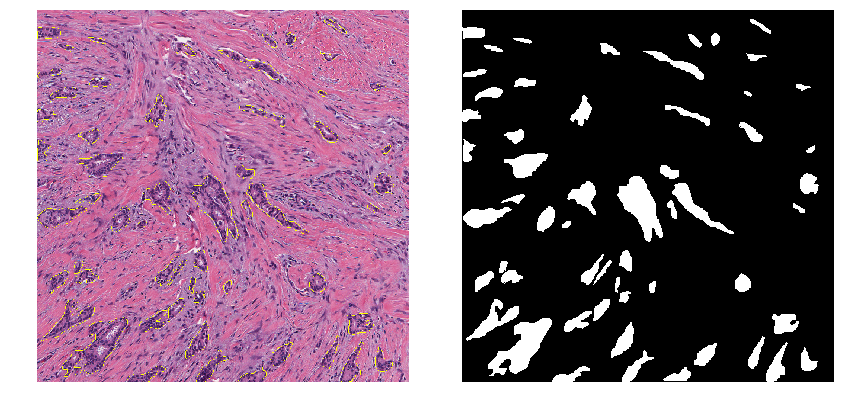

Displaying: epi/8974_00014.tif and epi/masks/8974_00014_mask.png


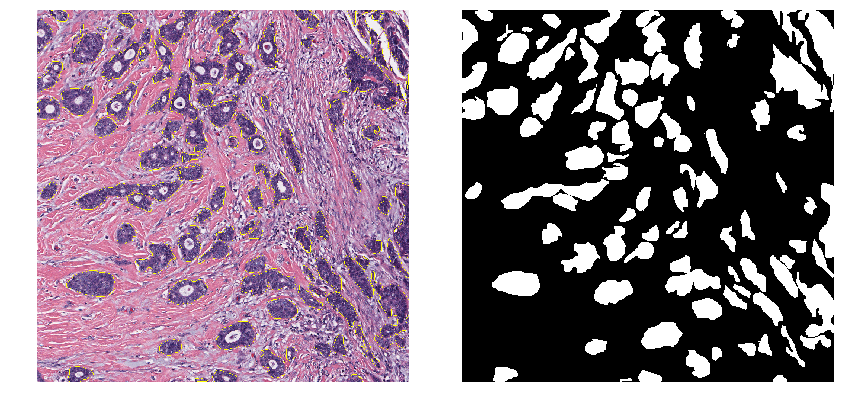

Displaying: epi/12875_00002.tif and epi/masks/12875_00002_mask.png


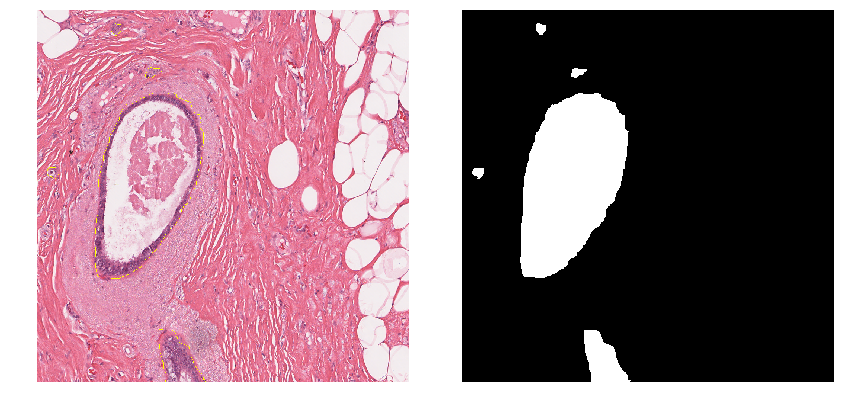

In [3]:
import matplotlib.pyplot as plt
from skimage import io, segmentation

number_of_images_to_display = 3

# For each original image with mask
for (orig_image, mask_image) in orig_images_with_mask[0:number_of_images_to_display]:
    print("Displaying:", orig_image,"and",mask_image)
    org_im = io.imread(orig_image)
    mask_im = io.imread(mask_image)
    mask_edges = segmentation.mark_boundaries(org_im, mask_im)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(mask_edges)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(mask_im, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Time to sample the data.

In the code below, you can control the number of samples per images, and also the size of the samples. Note, if changing the size of the data, you need  to ensure that you update subsequent parts of the notebook that assumes the size of 64.

In this exercise, we will also split the data into separate training and test sets right away.

In [0]:
# Simple function to sample an image
def sample_and_save(image, pos, sample_size, folder, sample_counter):
    for xy in pos:
        sample_counter = sample_counter + 1
        x = xy[0]
        y = xy[1]
        sample = image[x-sample_size//2:x+sample_size//2,
                       y-sample_size//2:y+sample_size//2,
                       :]
        io.imsave(folder + str(sample_counter).zfill(5) + ".png", sample)

    return sample_counter  

Run the cell below once only, as it might take considerable time to run.

In [5]:
from skimage.morphology import erosion, square
import numpy as np

# Parameters for sampling
sample_size = 64
samples_per_image = 10

# Set and create folders for samples
folder = "epi"
output_folder = os.path.join(folder,"samples")
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)
for sample_category in ["train","test"]:
    os.mkdir(os.path.join(output_folder,sample_category))
    os.mkdir(os.path.join(output_folder,sample_category,"positive"))
    os.mkdir(os.path.join(output_folder,sample_category,"negative"))
  
# Shuffle our cases
np.random.seed(123)
np.random.shuffle(orig_images_with_mask)

# Start sampling patches for training, but we'll change sample category 
# as we move along based upon our counter
counter = 0
sample_category = "train"
# Set sample counters
pos_sample_counter = 0
neg_sample_counter = 0
# For each original image with mask
for (orig_image, mask_image) in orig_images_with_mask:
    counter = counter + 1
    
    if counter == 35:
        # Change to test
        sample_category = "test"
        # Reset sample counters
        pos_sample_counter = 0
        neg_sample_counter = 0
    
    print("Processing", orig_image,"and",mask_image,"to create",sample_category)
    org_im = io.imread(orig_image)
    mask_im = io.imread(mask_image)
    
    # Create foreground and background masks
    fg_im = np.zeros(mask_im.shape)
    bg_im = np.zeros(mask_im.shape)
    fg_im[mask_im == 255] = 1
    bg_im[mask_im != 255] = 1
    
    # Erode masks
    fg_im_eroded = erosion(fg_im, square(sample_size//2))
    bg_im_eroded = erosion(bg_im, square(sample_size//2))
    
    # Remove masks close to the edges of images
    im_size = org_im.shape[0]
    fg_im_eroded[:sample_size//2,:] = 0
    fg_im_eroded[im_size-sample_size//2:,:] = 0
    fg_im_eroded[:,:sample_size//2] = 0
    fg_im_eroded[:,im_size-sample_size//2:] = 0
    bg_im_eroded[:sample_size//2,:] = 0
    bg_im_eroded[im_size-sample_size//2:,:] = 0
    bg_im_eroded[:,:sample_size//2] = 0
    bg_im_eroded[:,im_size-sample_size//2:] = 0

    # Find indices to sample from
    pos_ind = np.where(fg_im_eroded==1)
    pos_ind = np.concatenate((np.expand_dims(pos_ind[0], axis=1),
                              np.expand_dims(pos_ind[1], axis=1)), axis=1)
    neg_ind = np.where(bg_im_eroded==1)
    neg_ind = np.concatenate((np.expand_dims(neg_ind[0], axis=1),
                              np.expand_dims(neg_ind[1], axis=1)), axis=1)
    
    # Shuffle indices
    np.random.seed(123)
    np.random.shuffle(pos_ind)
    np.random.seed(321)
    np.random.shuffle(neg_ind)

    # Get indices to use
    pos_ind = pos_ind[0:samples_per_image+1,:]
    neg_ind = neg_ind[0:samples_per_image+1,:]

    # Sample the images
    pos_sample_counter = sample_and_save(org_im, pos_ind, sample_size, 
                                         os.path.join(output_folder, sample_category, "positive", "pos_"), 
                                         pos_sample_counter)
    neg_sample_counter = sample_and_save(org_im, neg_ind, sample_size, 
                                         os.path.join(output_folder, sample_category, "negative", "neg_"), 
                                         neg_sample_counter)

NameError: ignored

No need to worry about the warnings that are produced.

As before, we need to setup some libraries to use for deep learning.

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, Dense, Flatten
from keras.regularizers import l2
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback
import tensorflow as tf

def get_device():
    device_string = '/cpu:0'
    # Set to None to avoid using a GPU
    gpu=0
    if gpu is not None:
        device_string='/device:GPU:{0}'.format(gpu)
    return tf.device(device_string)

def _init_keras():
    # Setup the session to dynamically allocate memory
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    K.set_session(session)

# Init the default session to be used by Keras
_init_keras()

We list the samples we have available and split them into train, validation and test.

In [0]:
import matplotlib.image
from sklearn.model_selection import train_test_split

def load_data(datadir, sample_category, apply_train_test_split=True):
    pos_filenames = glob.glob(os.path.join(datadir,sample_category,"positive", "*.png"))
    neg_filenames = glob.glob(os.path.join(datadir,sample_category,"negative", "*.png"))
    
    pos_images = [matplotlib.image.imread(fname) for fname in pos_filenames]
    neg_images = [matplotlib.image.imread(fname) for fname in neg_filenames]
    
    X = np.vstack([np.array(pos_images, dtype=np.float32), np.array(neg_images, dtype=np.float32)])
    y = np.array([1]*len(pos_images) + [0]*len(neg_images), dtype=np.int32)
    
    if apply_train_test_split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            stratify=y,
                                                            random_state=123)
    
        return (X_train, y_train), (X_test, y_test)
    else:
        p = np.random.permutation(len(X))
        return (X[p], y[p])

In [0]:
# This will load data from disk and cache it.
(X_train, y_train), (X_val, y_val) = load_data("epi/samples", "train")
(X_test, y_test) = load_data("epi/samples", "test", apply_train_test_split=False)

Check the size of the training and test sets, as well as the dimension of each array

In [0]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

____
## Exercise
Can you spot the difference in the shape (size) of the data as compared to the previous exercise?
____

We can visualize the image patches by plotting some of them

In [0]:
def plot_patches(X, y, y_true=None, to_plot=None):    
    to_plot = to_plot or len(X)
    plt.figure(figsize=(16,8))
    for i in range(to_plot):
        plt.subplot(1, to_plot, i+1)
        plt.imshow(X[i].reshape((64, 64, 3)), interpolation='nearest')
        plt.text(0, 0, y[i], color='black', 
                 bbox=dict(facecolor='white', alpha=1))
        if y_true is not None:
            plt.text(0, 32, y_true[i], color='black', 
                     bbox=dict(facecolor='white', alpha=1))
            
        plt.axis('off')
    plt.show()

In [0]:
print("Training samples")
plot_patches(X_train, y_train, to_plot=10)
print("Validation samples")
plot_patches(X_val, y_val, to_plot=10)
print("Test samples")
plot_patches(X_test, y_test, to_plot=10)

To get started, we will use exactly the same approach as last time, but adjusted for somewhat large image patches and the fact that they are RGB images. 

## MLP

We start off with an MLP model.

In [0]:
# Define helper functions
def to_tensors(X, y):
    return X[:, :, :, :], to_categorical(y, num_classes=2)

class LogCallback(Callback):            
    def on_epoch_end(self, epoch, logs=None):                                        
        print("{}: L: {:.7} A: {:.7} VL: {:.7} VA: {:.7}".format(epoch,                                                                            
                                                                 logs['loss'], 
                                                                 logs['acc'], 
                                                                 logs['val_loss'], 
                                                                 logs['val_acc'])) 

def crossentropy_logits(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)
  
def to_tensors(X, y):
    # Convert X into a 4D tensor and y into a 2D tensor with 1-hot encoding
    return X[:, :, :, :], to_categorical(y, num_classes=2)

In [0]:
# Define MLP model to use
def build_mlp_model():
    # Images are 3 channel and 64x64
    input = Input(shape=(64, 64, 3))
    x = Flatten()(input)
    x = Dropout(rate=0.8)(x)
    x = Dense(512, activation='relu')(x)    
    x = Dropout(rate=0.8)(x)
    x = Dense(512, activation='relu')(x)    
    x = Dense(2)(x)
    return Model(input, x)

In [0]:
# Load data
(X_train, y_train), (X_val, y_val) = load_data("epi/samples", "train")
(X_test, y_test) = load_data("epi/samples", "test", apply_train_test_split=False)

# Plot example data
print("Example patches of epithelium and stroma")
plot_patches(X_train, y_train, to_plot=10)

# Convert to expected format
X_train, y_train = to_tensors(X_train, y_train)
X_val, y_val = to_tensors(X_val, y_val)
X_test, y_test = to_tensors(X_test, y_test)

# Run training
with get_device():
    model = build_mlp_model()

    optimizer = SGD(lr=0.003)
    model.compile(optimizer=optimizer, loss = crossentropy_logits, metrics=['accuracy'])

    n_train = -1
    logs = model.fit(X_train[:n_train], y_train[:n_train], 
                     validation_data=(X_val, y_val), 
                     epochs=25,
                     verbose=0, callbacks=[LogCallback()])

# Display training curves    
plt.plot(logs.history['acc'])
plt.plot(logs.history['val_acc'])
plt.show()

# Predict on test data
y_proba_test = model.predict(X_test)
y_pred_test = np.argmax(y_proba_test, axis=-1)
y_true = np.argmax(y_test, axis=-1)
errors = y_pred_test != y_true

# Compute the accuracy    
print("Accuracy: {}".format(1.0-np.mean(errors)))

# Plot the first examples
print("Some predicted examples")
to_evaluate = 15
X_eval = X_test[:to_evaluate]    
y_eval = y_pred_test[:to_evaluate]
plot_patches(X_eval, y_eval, y_true=y_true[:to_evaluate])

# Plot the first error examples
print("Some false predictions")
X_eval = X_test[np.where(errors)][:to_evaluate]
y_eval = y_pred_test[np.where(errors)][:to_evaluate]
plot_patches(X_eval, y_eval)

## CNN

That didn't work very well. Let's try our CNNs instead.

In [0]:
# Define CNN model to use
def build_conv_model():
    # Images are 3 channel and 64x64
    input = Input(shape=(64, 64, 3))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dropout(rate=0.8)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(2)(x)
    return Model(input, x)

In [0]:
# Load data
(X_train, y_train), (X_val, y_val) = load_data("epi/samples", "train")
(X_test, y_test) = load_data("epi/samples", "test", apply_train_test_split=False)

# Plot example data
print("Example patches of epithelium and stroma")
plot_patches(X_train, y_train, to_plot=10)

# Convert to expected format
X_train, y_train = to_tensors(X_train, y_train)
X_val, y_val = to_tensors(X_val, y_val)
X_test, y_test = to_tensors(X_test, y_test)

# Run training
with get_device():
    model = build_conv_model()

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss = crossentropy_logits, metrics=['accuracy'])

    n_train = -1
    logs = model.fit(X_train[:n_train], y_train[:n_train], 
                     validation_data=(X_val, y_val), 
                     epochs=25,
                     verbose=0,
                     callbacks=[LogCallback()])

# Display training curves 
plt.plot(logs.history['acc'])
plt.plot(logs.history['val_acc'])
plt.show()

# Predict on test data
with get_device():
    y_proba_test = model.predict(X_test)

y_pred_test = np.argmax(y_proba_test, axis=-1)
y_true = np.argmax(y_test, axis=-1)
errors = y_pred_test != y_true

# Compute the accuracy    
print("Test accuracy: {}".format(1.0-np.mean(errors)))

# Plot the first examples
print("Some predicted examples")
to_evaluate = 15
X_eval = X_test[:to_evaluate]    
y_eval = y_pred_test[:to_evaluate]
plot_patches(X_eval, y_eval, y_true=y_true[:to_evaluate])

# Plot the first error examples
print("Some false predictions")
X_eval = X_test[np.where(errors)][:to_evaluate]
y_eval = y_pred_test[np.where(errors)][:to_evaluate]
plot_patches(X_eval, y_eval)

As we can note in this exercise, we don't have that many images to sample from, only about 40 images. Also, we haven't sampled our data that densely, i.e. just a few samples from each image. This means that we just have a few image samples to train on and with a limited variation. 

The natural approach to handle this would of course be to collect more images, annotate them and/or to sample more densely from the images that are available. Sometimes (often) this is not possible, and instead we need to use other techniques to create more training data. The most common approach is data augmentation.

## Data Augmentation

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (or a combination of the above). However, in order to achieve this we need data with sufficient variation.
![](https://github.com/fordanic/cmiv-ai-course/blob/master/notebooks/figures/data_augmentation.png?raw=1)
This essentially is the premise of data augmentation. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our target application may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional synthetically modified data, taking into account these different variations.

___
## Exercise
What are the variations that would be relevant to consider in a context of training an image classifier for radiology respectively pathology?
___

In the following, we'll make use of the class `ImageDataGenerator` in Keras to construct additional training data.

First we run an example of offline data augmentation, i.e.we create additional data prior to running the training. In this case, we only create 20 new versions from the first image patch among our training samples.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

if os.path.exists("preview"):
    shutil.rmtree("preview")
os.mkdir("preview")

# The class ImageDataGenerator is used to create additional data
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

x = X_train[0,:,:,:]
x = np.transpose(x) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
x = np.transpose(x)
print(x.shape)

# The .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(X_train[0:1,:,:,:], batch_size=1, 
                          save_to_dir='preview', save_prefix='aug', save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Next, we can look at the data that we have created.

In [0]:
aug_filenames = glob.glob(os.path.join("preview", "*.png"))

aug_images = [matplotlib.image.imread(fname) for fname in aug_filenames]

X_aug = np.vstack([np.array(aug_images, dtype=np.float32)])
y_aug = np.array([1]*len(aug_images), dtype=np.int32)

# Plot example data
print("Example of augmented image samples")
plot_patches(X_aug, y_aug, to_plot=20)    

However, for the actual training we will instead use oneline data augmentation, i.e. additional images will be created on the fly as we run the training. To do this we will make use of a data generator.

In [0]:
# Define CNN model to use
def build_conv_model():
    # Images are 3 channel and 64x64
    input = Input(shape=(64, 64, 3))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dropout(rate=0.8)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(2)(x)
    return Model(input, x)

In [0]:
# Load data
(X_train, y_train), (X_val, y_val) = load_data("epi/samples", "train")
(X_test, y_test) = load_data("epi/samples", "test", apply_train_test_split=False)

# Plot example data
print("Example patches of epithelium and stroma")
plot_patches(X_train, y_train, to_plot=10)

# Convert to expected format
X_train, y_train = to_tensors(X_train, y_train)
X_val, y_val = to_tensors(X_val, y_val)
X_test, y_test = to_tensors(X_test, y_test)

# Create a data generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

# Run training
with get_device():
    model = build_conv_model()

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss = crossentropy_logits, metrics=['accuracy'])

    n_train = -1
    
    # Fits the model on batches with real-time data augmentation:
    logs= model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                              steps_per_epoch=len(X_train) / 8, epochs=25,
                              validation_data=(X_val, y_val), 
                              verbose=0,
                              callbacks=[LogCallback()])
    
# Display training curves 
plt.plot(logs.history['acc'])
plt.plot(logs.history['val_acc'])
plt.show()

# Predict on test data
with get_device():
    y_proba_test = model.predict(X_test)

y_pred_test = np.argmax(y_proba_test, axis=-1)
y_true = np.argmax(y_test, axis=-1)
errors = y_pred_test != y_true

# Compute the accuracy    
print("Test accuracy: {}".format(1.0-np.mean(errors)))

# Plot the first examples
print("Some predicted examples")
to_evaluate = 15
X_eval = X_test[:to_evaluate]    
y_eval = y_pred_test[:to_evaluate]
plot_patches(X_eval, y_eval, y_true=y_true[:to_evaluate])

# Plot the first error examples
print("Some false predictions")
X_eval = X_test[np.where(errors)][:to_evaluate]
y_eval = y_pred_test[np.where(errors)][:to_evaluate]
plot_patches(X_eval, y_eval)

___
## Exercise
Explore to see if you can achieve the same results by using data augmentation as you can if you would increase the number of image patches sampled from each of image.
___